In [1]:
import sys
sys.path.append('../')

import numpy as np
import cv2
import lib.utils as utils
import math
import matplotlib.pyplot as plt

load image and generate binary image

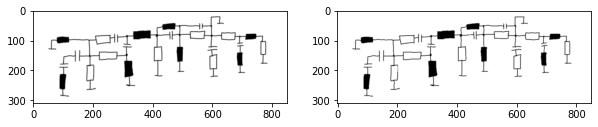

In [2]:
image = utils.loadImage(path="./../resources/testImages",name="raf_1.png", resize=(850,None))
(thresh, binary) = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)


#kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
#binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
#binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

utils.saveImage(name="image.png", image=image)
utils.saveImage(name="binary.png", image=binary)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image, interpolation="bilinear", cmap="gray")
plt.subplot(1,2,2)
plt.imshow(binary, interpolation="bilinear", cmap="gray")
plt.show()


filter functions

In [3]:
def getRegion(size, pos, image):
    xOff = math.floor(size[0]/2)
    yOff = math.floor(size[1]/2)
    return image[pos[1]-yOff:pos[1]+yOff+1, pos[0]-xOff:pos[0]+xOff+1]

def equal(filter, img):
    for y in range(0, len(filter)):
        for x in range(0, len(filter[y])):
            if filter[y][x] != -1 and filter[y][x] != img[y][x]:
                return False
    return True

def applyFilterOnPoints(filter, image, points):
    features = []
    size = [len(filter), len(filter[0])]
    for (x, y) in points:
        try:
            if equal(filter, getRegion(size, (x, y), image)):
                features.append((x,y))
        except:
            pass
    return features

def rotateFilter(filter):
    rotatedFilters = []
    for k in range(0,4):
        rotatedFilters.append(np.rot90(filter, k))
    return rotatedFilters

get Black pixel

In [4]:
points = []
for y in range(0, len(binary)):
    for x in range(0, len(binary[y])):
        if binary[y][x] == 0:
            points.append((x,y))

remove black sections

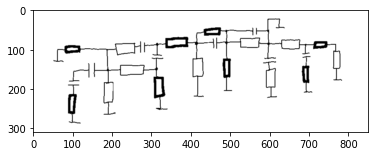

In [5]:
filter = np.full((13, 13), 0)
features = applyFilterOnPoints(filter, binary, points)

for (x,y) in features:
    binary[y][x] = 255

utils.saveImage(name="ohneSpulen.png", image=binary)
plt.imshow(binary, interpolation="bilinear", cmap="gray")

thinn image

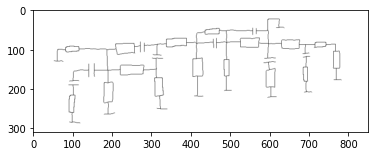

In [6]:
thinn = utils.thinnImage(binary)

utils.saveImage(name="thinn.png", image=thinn)
plt.imshow(thinn, interpolation="bilinear", cmap="gray")

replace certain features

In [7]:
def addFeature(feature, replacement, rotate=True, flip=False):
    features = []
    if rotate:
        feature = rotateFilter(feature)
        replacement = rotateFilter(replacement)
        for i in range(0,4):
            features.append([feature[i], replacement[i]])
    else:
        features.append([feature, replacement])
    if flip:
        flipped = []
        for i in range(0, len(features)):
            flipped.append([np.flip(features[i][0],1), np.flip(features[i][1],1)])
        features += flipped
    return features

In [8]:
def getFeatures():
    features = []
    
    feature = [[255,0,255],[0,0,0],[255,0,255]]
    replacement = [[255,0,255],[0,255,0],[255,0,255]]
    features += addFeature(feature, replacement, rotate=False)

    feature = [[255,0,-1],[-1,0,0],[0,0,-1]]
    #replacement = [[255,0,0],[-1,0,255],[0,0,-1]]
    replacement = [[255,0,255],[-1,0,0],[0,255,-1]]
    features += addFeature(feature, replacement, flip=True)

    feature = [[-1,255,0],[0,0,255],[255,0,-1]]
    replacement = [[-1,255,0],[0,255,0],[255,0,-1]]
    features += addFeature(feature, replacement)
    
    feature = [[-1,255,-1],[0,0,0],[255,0,255]]
    replacement = [[-1,255,-1],[0,255,0],[255,0,255]]
    features += addFeature(feature, replacement)
    
    feature = [[-1,255,255],[0,0,255],[255,0,-1]]
    replacement = [[-1,255,255],[0,255,255],[255,0,-1]]
    features += addFeature(feature, replacement)

    return features

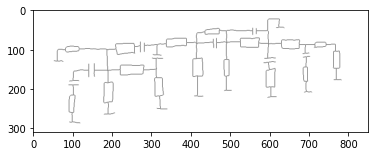

In [9]:
features = getFeatures()

for feature in features:
    featureList = applyFilterOnPoints(feature[0], thinn, points)
    for (xOff, yOff) in featureList:
        for y in range(0, len(feature[1])):
            for x in range(0, len(feature[1][y])):
                if feature[1][y][x] != -1:
                    thinn[yOff + y - 1][xOff + x - 1] = feature[1][y][x]

utils.saveImage(name="modifiedThinn.png", image=thinn)
plt.imshow(thinn, interpolation="bilinear", cmap="gray")